In [1]:
logger_name = "lstnet"

# Path appended in order to import from util
import sys
# from util.model_util import LoadModel, SaveModel, SaveResults, SaveHistory
# from util.Msglog import LogInit

from datetime import datetime

#from lstnet_util import GetArguments, LSTNetInit
from pandas_data_util import DataUtil
#from lstnet_model import PreSkipTrans, PostSkipTrans, PreARTrans, PostARTrans, LSTNetModel, ModelCompile
#from lstnet_plot import AutoCorrelationPlot, PlotHistory, PlotPrediction

import tensorflow as tf
import argparse

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras import backend as K


# LOAD DATA

### Filter data to be premium tier, internal IP, and n1-standard-16 machines

In [2]:
# Reading data
filename = 'data/bq_results_09082022.csv'
trainpercent = 0.6
validpercent = 0.2
horizon=0
window=10
normalize=0

# query='vm_1_gce_network_tier == "premium"'
query = 'vm_1_gce_network_tier == "premium" and vm_1_machine_type == "n1-standard-16" and ip_type == "internal" and tcp_congestion_control == "bbr" and sending_zone != "asia-east2-a"'

Data = DataUtil(filename,
                trainpercent,
                validpercent,
                horizon,
                window,
                normalize=normalize,
                query=query)


/home/derek/projects/ml/tf_2.4_src/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,14,20,45,82,83,84) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Index(['run_uri', 'vm_1_cloud', 'vm_2_cloud', 'sending_zone', 'receiving_zone',
       'vm_1_machine_type', 'vm_2_machine_type', 'ip_type',
       'vm_1_gce_network_tier', 'vm_2_gce_network_tier',
       ...
       'sending_zone_hour_sin', 'receiving_zone_hour_cos',
       'receiving_zone_hour_sin', 'kernel_version', 'n1-standard-16',
       'external', 'internal', 'vm_1_os_info_trunc', 'bbr', 'cubic'],
      dtype='object', length=109)


/home/derek/projects/ml/tf_2.4_src/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [3]:
val_performance = {}
performance = {}

In [4]:
#Root relative squared error
def tf_rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square(y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = K.sqrt(K.mean(K.square(y_true - y_pred), axis=None))
    den = K.std(y_true, axis=None)
    
    return num / den

def rse_test1(y_true, y_pred):
    return K.square(y_true - y_pred)

def rse_test2(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred), axis=None))

def rse_test3(y_true, y_pred):
    return K.std(y_true, axis=None)

def rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square( y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = np.sqrt(np.mean(np.square(y_true - y_pred), axis=None))
    den = np.std(y_true, axis=None)
    
    return num / den

def tf_corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true - K.mean(y_true, axis=0)
    num2 = y_pred - K.mean(y_pred, axis=0)
    
    num  = K.mean(num1 * num2, axis=0)
    den  = K.std(y_true, axis=0) * K.std(y_pred, axis=0)
    
    return K.mean(num / den)

def corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true - np.mean(y_true, axis=0)
    num2 = y_pred - np.mean(y_pred, axis=0)
    
    num  = np.mean(num1 * num2, axis=0)
    den  = np.std(y_true, axis=0) * np.std(y_pred, axis=0)
    
    return np.mean(num / den)

def single_rse(y_true, y_pred):
    #
    # The formula is:
    #           K.sqrt(K.sum(K.square(y_true - y_pred)))     
    #    RSE = -----------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)))       
    #
    #           K.sqrt(K.sum(K.square(y_true - y_pred))/(N-1))
    #        = ----------------------------------------------------
    #           K.sqrt(K.sum(K.square(y_true_mean - y_true)/(N-1)))
    #
    #
    #           K.sqrt(K.mean(K.square(y_true - y_pred)))
    #        = ------------------------------------------
    #           K.std(y_true)
    #
    num = K.sqrt(K.mean(K.square(y_true[:,0] - y_pred[:,0]), axis=None))
    den = K.std(y_true, axis=None)
    
    return num / den


def single_corr(y_true, y_pred):
    #
    # This function calculates the correlation between the true and the predicted outputs
    #
    num1 = y_true[:,0] - K.mean(y_true[:,0], axis=0)
    num2 = y_pred[:,0] - K.mean(y_pred[:,0], axis=0)
    
    num  = K.mean(num1 * num2, axis=0)
    den  = K.std(y_true[:,0], axis=0) * K.std(y_pred[:,0], axis=0)
    
    return K.mean(num / den)

def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

In [5]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10,
                                                mode='min')

In [6]:
Data.columns

['pandas_datetime',
 'iperf_throughput_1_thread',
 'iperf_throughput_32_threads',
 'ping_average_latency',
 'tcp_max_receive_buffer',
 'sending_zone_day_cos',
 'sending_zone_day_sin',
 'receiving_zone_day_cos',
 'receiving_zone_day_sin',
 'sending_zone_hour_cos',
 'sending_zone_hour_sin',
 'receiving_zone_hour_cos',
 'receiving_zone_hour_sin',
 'kernel_version',
 'group_mean',
 'group_stddev']

In [7]:
Data.train[0][0]

array([[Timestamp('2022-03-03 04:11:17.582279+0000', tz='UTC'),
        0.38160751190610326, -0.7276882532811109, -1.6589071823410038,
        0.0, -0.900968867902419, 0.43388373911755823, -0.900968867902419,
        0.43388373911755823, -1.0, 1.2246467991473532e-16, -1.0,
        1.2246467991473532e-16, -2.6737588548687152, 25923.007194244605,
        2176.550257101131],
       [Timestamp('2022-03-04 06:55:46.812430+0000', tz='UTC'),
        0.6505136838410618, -0.30980381656815337, -1.6591257682116063,
        0.0, -0.9009688679024191, -0.433883739117558,
        -0.9009688679024191, -0.433883739117558, -0.8660254037844388,
        -0.4999999999999997, -0.8660254037844388, -0.4999999999999997,
        -2.6737588548687152, 25923.007194244605, 2176.550257101131],
       [Timestamp('2022-03-05 10:11:20.458815+0000', tz='UTC'),
        1.4669257465648209, 0.4227898090455842, -1.6539439972790941, 0.0,
        -0.2225209339563146, -0.9749279121818236, -0.2225209339563146,
        -0.974927

In [8]:
Data.train[0][:,:,1:12][0].shape

(10, 11)

In [9]:
Data.train[1][:,0]

array([Timestamp('2022-03-14 10:15:48.291610+0000', tz='UTC'),
       Timestamp('2022-03-15 13:15:39.680529+0000', tz='UTC'),
       Timestamp('2022-03-16 16:16:57.966655+0000', tz='UTC'), ...,
       Timestamp('2022-06-03 11:10:47.358064+0000', tz='UTC'),
       Timestamp('2022-06-04 16:24:33.753598+0000', tz='UTC'),
       Timestamp('2022-06-05 17:01:43.350594+0000', tz='UTC')],
      dtype=object)

In [10]:
data_col_top = 13

In [11]:
adjusted_data_columns = Data.columns[1:data_col_top]

In [12]:
adjusted_data_columns

['iperf_throughput_1_thread',
 'iperf_throughput_32_threads',
 'ping_average_latency',
 'tcp_max_receive_buffer',
 'sending_zone_day_cos',
 'sending_zone_day_sin',
 'receiving_zone_day_cos',
 'receiving_zone_day_sin',
 'sending_zone_hour_cos',
 'sending_zone_hour_sin',
 'receiving_zone_hour_cos',
 'receiving_zone_hour_sin']

In [13]:
num_vars = len(adjusted_data_columns)

In [14]:
data_train_x_float32 = np.array(list(Data.train[0][:,:,1:data_col_top])).astype(np.float32)
data_train_y_float32 = np.array(list(Data.train[1][:,1:data_col_top])).astype(np.float32)
data_train_y_float32_32_thread_reshaped = data_train_y_float32[:,1].reshape(data_train_y_float32[:,1].shape[0],1)
data_train_y_float32_1_thread_reshaped = data_train_y_float32[:,0].reshape(data_train_y_float32[:,0].shape[0],1)

data_valid_x_float32 = np.array(list(Data.valid[0][:,:,1:data_col_top])).astype(np.float32)
data_valid_y_float32 = np.array(list(Data.valid[1][:,1:data_col_top])).astype(np.float32)
data_valid_y_float32_32_thread_reshaped = data_valid_y_float32[:,1].reshape(data_valid_y_float32[:,1].shape[0],1)
data_valid_y_float32_1_thread_reshaped = data_valid_y_float32[:,0].reshape(data_valid_y_float32[:,0].shape[0],1)

data_test_x_float32 = np.array(list(Data.test[0][:,:,1:data_col_top])).astype(np.float32)
data_test_y_float32 = np.array(list(Data.test[1][:,1:data_col_top])).astype(np.float32)
data_test_y_float32_32_thread_reshaped = data_test_y_float32[:,1].reshape(data_test_y_float32[:,1].shape[0],1)
data_test_y_float32_1_thread_reshaped = data_test_y_float32[:,0].reshape(data_test_y_float32[:,0].shape[0],1)

In [15]:
accuracy_stats = {}
accuracy_stats['rmse'] = {}
accuracy_stats['rse'] = {}
accuracy_stats['corr'] = {}
accuracy_stats['accuracy'] = {}
accuracy_stats['mae'] = {}
accuracy_stats['predicted'] = {}
accuracy_stats['mse'] = {}

In [16]:
import scipy
import matplotlib.cm as cm

def SimpleAnomalyDetection(actual, predicted, data_high, data_low=0):
  # Finds average difference for entire data range
  # if point is more different than this, it is an anomaly
  # return anomaly list

  anomaly_index_list = []
  count = 0
  total=0
  for x in range(data_low, data_high):
      difference = abs(actual[x]-predicted[x])
      total = difference + total
      count += 1
  average = total / count
  print(f"The Average is: {average}")
  count = 0
  for x in range(data_low, data_high):
      difference = abs(actual[x]-predicted[x])
      if difference > 3*average:
          # anomaly_list.append(data_test_y_float32_32_thread_reshaped[x])
          # anomaly_list_x_coords.append(count)
          anomaly_index_list.append(x)
      count += 1
  print(anomaly_index_list)
  return anomaly_index_list

## Simple MLP

Here we are testing the effectiveness of a simple ANN (MLP) on our dataset

the output here is 32 thread throughput

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10,
                                                mode='min')

In [18]:
linear = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,num_vars)),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(units=20),
    tf.keras.layers.Dense(units=1),
])

In [19]:
linear.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf_rse, 
                         tf_corr, 
                         tf.metrics.MeanAbsoluteError(), 
                         tf.metrics.MeanSquaredError(), 
                         tf.metrics.RootMeanSquaredError(), 
                         tf.metrics.MeanAbsolutePercentageError()
                        ])

In [20]:
history = linear.fit(data_train_x_float32, 
           data_train_y_float32_32_thread_reshaped,
           epochs=1000, 
           validation_data=(data_valid_x_float32, 
                            data_valid_y_float32_32_thread_reshaped), 
           callbacks=[early_stopping],
           verbose=0)

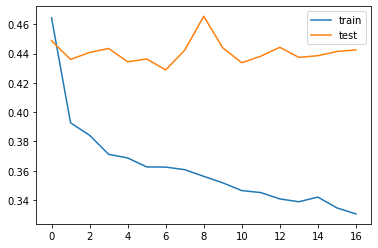

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [22]:
linear_stats = linear.evaluate(data_test_x_float32, data_test_y_float32_32_thread_reshaped)

linear_stats

149/149 [==============================] - 0s 3ms/step - loss: 0.5845 - tf_rse: 1.0361 - tf_corr: 0.1132 - mean_absolute_error: 0.5116 - mean_squared_error: 0.5845 - root_mean_squared_error: 0.7645 - mean_absolute_percentage_error: 180.5732


[0.5844890475273132,
 1.0361225605010986,
 0.1132030263543129,
 0.5116309523582458,
 0.5844890475273132,
 0.7645188570022583,
 180.57322692871094]

In [24]:
linear_predicted = linear.predict(data_test_x_float32)

np.save('predicted_results/mlp_predicted.npy', linear_predicted)
np.savetxt('predicted_results/mlp_predicted.txt', linear_predicted)
linear.save_weights('./checkpoints/linear_weights')

In [25]:
linear_predicted.shape

(4754, 1)

In [26]:
data_train_y_float32[:,1]

array([-0.47690824, -0.36854953,  0.16238338, ...,  0.40551165,
        0.81870633, -1.754751  ], dtype=float32)

In [27]:
data_test_y_float32_32_thread_reshaped.shape

(4754, 1)

In [28]:
from scipy.stats import iqr
import matplotlib.cm as cm
inquartileRange = iqr(data_test_y_float32_32_thread_reshaped,interpolation = 'midpoint')
print(inquartileRange)
higherRange = inquartileRange * 1.5

half = data_test_y_float32_32_thread_reshaped.shape[0] // 2
 
import numpy as np
# First quartile (Q1)
#print(Data.test[])
Q1 = np.median(data_test_y_float32_32_thread_reshaped[0:half])
  
# Third quartile (Q3)
Q3 = np.median(data_test_y_float32_32_thread_reshaped[half:])
  
# Interquartile range (IQR)
IQR = Q3 - Q1
print(f"IQR: {IQR}")
# Quartile Deviation
qd = IQR / 2
  
print(f"Quartile Deviation: {qd}")
highRange = IQR + qd
lowRange = IQR - qd
print(f"High Range: {highRange}")
print(f"Low Range: {lowRange}")

0.8262658938765526
IQR: 0.1920343041419983
Quartile Deviation: 0.09601715207099915
High Range: 0.28805145621299744
Low Range: 0.09601715207099915


In [29]:
data_test_y_float32_32_thread_reshaped

array([[-0.1498575 ],
       [ 0.4699345 ],
       [ 0.6627093 ],
       ...,
       [ 0.6271657 ],
       [ 0.15596579],
       [ 0.17151612]], dtype=float32)

In [30]:
linear_predicted

array([[0.3094934 ],
       [0.2850835 ],
       [0.34973598],
       ...,
       [0.494184  ],
       [0.41932702],
       [0.4274953 ]], dtype=float32)

The Average is: [0.5624566]
[35, 64, 123, 239, 282, 288, 427, 468, 663, 692, 797, 845, 1043, 1050, 1107, 1167, 1240, 1246, 1252, 1253, 1258, 1267, 1269, 1272, 1273, 1278, 1279, 1283, 1293, 1303, 1307, 1313, 1314, 1316, 1334, 1336, 1337, 1338, 1343, 1346, 1347, 1353, 1359, 1361, 1364, 1370, 1371, 1377, 1380, 1381, 1392, 1395, 1422, 1423, 1425, 1426, 1427, 1432, 1433, 1443, 1446, 1452, 1456, 1457, 1489, 1544, 1545, 1556, 1560, 1561, 1571, 1577, 1585, 1586, 1587, 1592, 1594, 1600, 1601, 1602, 1606, 1617, 1622, 1627, 1650, 1655, 1668, 1806, 1808, 1882, 1964]
The len of anomalyList: 91


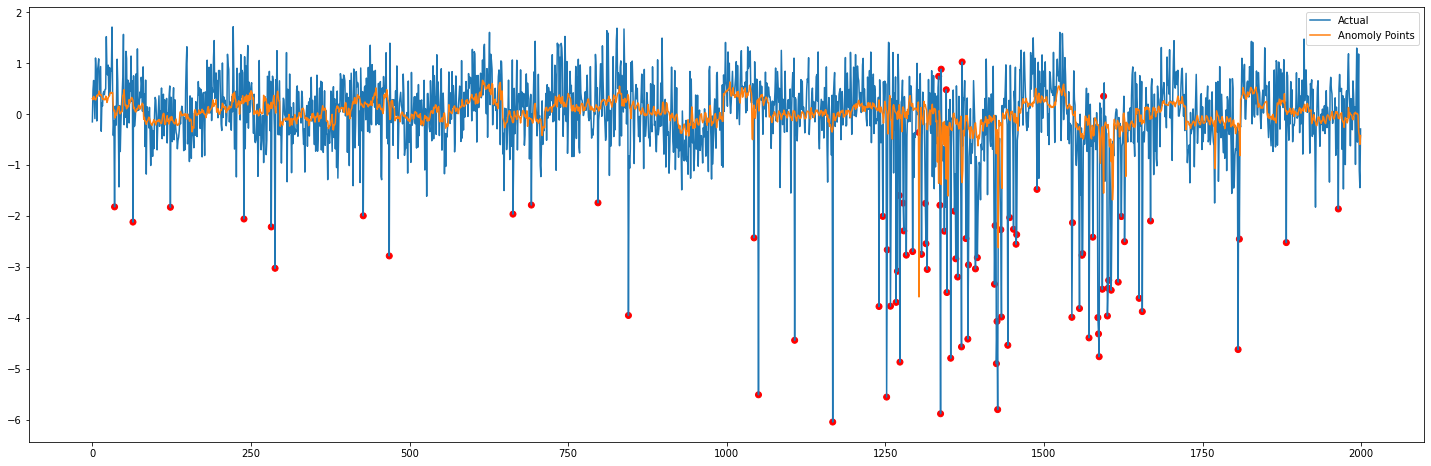

In [32]:
plt.figure(figsize=(25, 8))
data_high = 2000
data_low = 0
anomaly_index_list = SimpleAnomalyDetection(data_test_y_float32_32_thread_reshaped, linear_predicted, data_high, data_low=data_low)

anomaly_y_coords = []

for x in anomaly_index_list:
  anomaly_y_coords.append(data_test_y_float32_32_thread_reshaped[x])

print(f"The len of anomalyList: {len(anomaly_index_list)}")
colors = cm.rainbow(np.linspace(1, 1, len(anomaly_index_list)))
plt.plot(data_test_y_float32_32_thread_reshaped[data_low:data_high])
plt.plot(linear_predicted[data_low:data_high])
plt.scatter(anomaly_index_list, anomaly_y_coords, c=colors)

plt.legend(["Actual", "Anomoly Points"])
plt.show()

In [33]:
true_positives = []
false_positives = []
false_negatives = []
true_negatives = []
actual_anomalies = []

total = 0
count = 0

group_average = []


for i in range(0,2000):
  predicted_value = linear_predicted[i] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean
  actual_value = Data.test[1][i,2] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean
  difference = abs(actual_value-predicted_value)
  total = difference + total
  count += 1
average = total / count

for i in range(0,2000):
  predicted_value = linear_predicted[i] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean
  actual_value = Data.test[1][i,2] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean
  mean = Data.test[1][i,14]
  std = Data.test[1][i,15]
  
  anomaly = False
  if actual_value > mean + 1.4*std or actual_value < mean - 1.4*std:
    anomaly = True
  
  anomaly_detected = False
  difference = abs(actual_value-predicted_value)
  if difference > 1.4*average:
    anomaly_detected = True
  
  if anomaly:
    actual_anomalies.append(i)
    if anomaly_detected:
      true_positives.append(i)
    else:
      
      false_negatives.append(i)
  else:
    if anomaly_detected:
      # print(f'threshold: {anomaly_threshold}, predicted: {predicted_value}, actual: {actual_value}, diff: {difference}, ')
      false_positives.append(i)
    else:
      true_negatives.append(i)

true_positives_y_coords = []      
for x in true_positives:
  true_positives_y_coords.append(data_test_y_float32_32_thread_reshaped[x] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean)

false_positives_y_coords = []
for x in false_positives:
  false_positives_y_coords.append(data_test_y_float32_32_thread_reshaped[x] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean)

false_negatives_y_coords = []
for x in false_negatives:
  false_negatives_y_coords.append(data_test_y_float32_32_thread_reshaped[x] * Data.iperf_32_thread_std + Data.iperf_32_thread_mean)
  
print(f'TP {len(true_positives)}')
print(f'FP {len(false_positives)}')
print(f'FN {len(false_negatives)}')
print(f'TN {len(true_negatives)}')
print(f'Anomalies: {len(actual_anomalies)}')

TP 245
FP 172
FN 58
TN 1525
Anomalies: 303


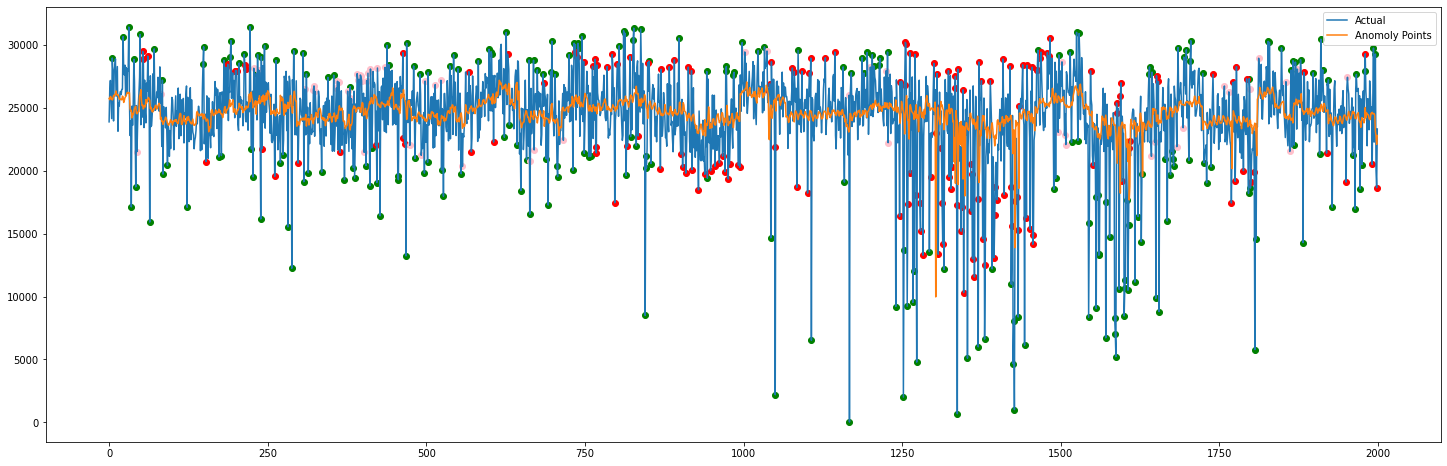

In [35]:
plt.figure(figsize=(25, 8))
plt.plot(data_test_y_float32_32_thread_reshaped[data_low:data_high]* Data.iperf_32_thread_std + Data.iperf_32_thread_mean)
plt.plot(linear_predicted[data_low:data_high]* Data.iperf_32_thread_std + Data.iperf_32_thread_mean)
plt.scatter(true_positives, true_positives_y_coords, c='g')
plt.scatter(false_positives, false_positives_y_coords, c='r')
plt.scatter(false_negatives, false_negatives_y_coords, c='pink')

plt.legend(["Actual", "Anomoly Points"])
plt.show()

In [36]:
data_test_y_float32_32_thread_reshaped

array([[-0.1498575 ],
       [ 0.4699345 ],
       [ 0.6627093 ],
       ...,
       [ 0.6271657 ],
       [ 0.15596579],
       [ 0.17151612]], dtype=float32)

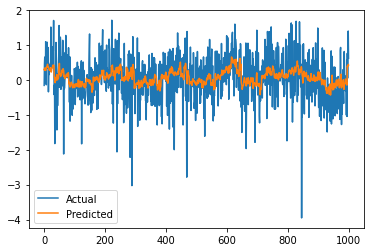

In [37]:
dataRange=1000

plt.plot(data_test_y_float32_32_thread_reshaped[0:dataRange])
plt.plot(linear_predicted[0:dataRange])
plt.legend(["Actual", "Predicted"])
plt.show()

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

mse = mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), linear_predicted.flatten())
rmse = sqrt(mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), linear_predicted.flatten()))
mae = mean_absolute_error(data_test_y_float32_32_thread_reshaped.flatten(), linear_predicted.flatten())
rse_val = rse(data_test_y_float32_32_thread_reshaped.flatten(), linear_predicted.flatten())
mape = mean_absolute_percentage_error(data_test_y_float32_32_thread_reshaped.flatten(), linear_predicted.flatten())

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')
print(f'MAPE: {mape}')

# accuracy_stats['rmse']['mlp'] = rmse
# accuracy_stats['rse']['mlp'] = rse_val
# # accuracy_stats['corr']['mlp'] = corr
# # accuracy_stats['accuracy']['mlp'] = acc
# accuracy_stats['mae']['mlp'] = mae
# accuracy_stats['predicted']['mlp'] = linear_predicted
# accuracy_stats['mse']['mlp'] = mse

MSE: 0.5844889879226685
RMSE: 0.7645187950094284
MAE: 0.5116310119628906
RSE: 0.9240967631340027
MAPE: 1.8057324886322021


## SIMPLE LSTM

Here we run our data through a simple lstm for comparison

In [42]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=40,
                                                mode='min')

In [43]:
# define lstm network

# lstm_model = tf.keras.models.Sequential([
#     # Shape [batch, time, features] => [batch, time, lstm_units]
#     tf.keras.layers.GRU(32, input_shape=(10), return_sequences=False),
#     # Shape => [batch, time, features]
#     tf.keras.layers.Dense(units=1)
# ])

ts_inputs = tf.keras.Input(shape=(10,num_vars))
x = tf.keras.layers.LSTM(units=250, dropout=0.1, recurrent_dropout=0.1)(ts_inputs)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1,activation='linear')(x)
lstm_model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

NotImplementedError: Cannot convert a symbolic Tensor (lstm_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), 
                         tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsolutePercentageError()])

In [41]:
lstm_model.summary()

NameError: name 'lstm_model' is not defined

In [ ]:
history = lstm_model.fit(data_train_x_float32, 
                         data_train_y_float32_32_thread_reshaped,
                         epochs=1000, 
                         validation_data=(data_valid_x_float32, 
                                          data_valid_y_float32_32_thread_reshaped), 
                         callbacks=[early_stopping],
                         shuffle=False,
                         verbose=0)

In [ ]:
lstm_stats = lstm_model.evaluate(data_test_x_float32, data_test_y_float32_32_thread_reshaped)
lstm_stats

In [ ]:
lstm_predicted = lstm_model.predict(data_test_x_float32).flatten()

np.save('predicted_results/lstm_predicted.npy', lstm_predicted)
np.savetxt('predicted_results/lstm_predicted.txt', lstm_predicted)
lstm_model.save_weights('./checkpoints/lstm_weights')

In [ ]:
lstm_predicted = np.load('predicted_results/lstm_predicted.npy')#*Data.normalize_std[0] + Data.normalize_mean[0]
# data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]
# def mean_absolute_percentage_error(y_true, y_pred): 
#   return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100
lstm_mape = mean_absolute_percentage_error(data_test_y_float32_32_thread_reshaped, lstm_predicted)
lstm_mape

In [ ]:
plt.plot(data_test_y_float32_32_thread_reshaped[0:500])
plt.plot(lstm_predicted[0:500])
plt.show()

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
data_high = 500
data_low = 0
anomaly_index_list = SimpleAnomalyDetection(data_test_y_float32_32_thread_reshaped, lstm_predicted, data_high, data_low=data_low)

anomaly_y_coords = []

for x in anomaly_index_list:
  anomaly_y_coords.append(data_test_y_float32_32_thread_reshaped[x])

print(f"The len of anomalyList: {len(anomaly_index_list)}")
colors = cm.rainbow(np.linspace(1, 1, len(anomaly_index_list)))
plt.plot(data_test_y_float32_32_thread_reshaped[data_low:data_high])
plt.plot(lstm_predicted[data_low:data_high])
plt.scatter(anomaly_index_list, anomaly_y_coords, c=colors)

plt.legend(["Actual", "Anomoly Points"])
plt.show()

In [ ]:
plt.figure(figsize=(25, 10))
plt.plot(data_test_y_float32_32_thread_reshaped,label="actual")
plt.plot(lstm_predicted, color='r',label="predicted")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

mse = mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), lstm_predicted)
rmse = sqrt(mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), lstm_predicted))
mae = mean_absolute_error(data_test_y_float32_32_thread_reshaped.flatten(), lstm_predicted)
rse_val = rse(data_test_y_float32_32_thread_reshaped.flatten(), lstm_predicted)
mape = mean_absolute_percentage_error(data_test_y_float32_32_thread_reshaped.flatten(), lstm_predicted.flatten())

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')
print(f'MAPE: {mape}')

accuracy_stats['rmse']['lstm'] = rmse
accuracy_stats['rse']['lstm'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['lstm'] = mae
accuracy_stats['predicted']['lstm'] = lstm_predicted
accuracy_stats['mse']['lstm'] = mse

In [ ]:
lstm_predicted.shape

In [ ]:
Data.test[1][:,0].shape

## Simple GRU

Do the same thing but with a GRU


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=40,
                                                mode='min')

In [ ]:
ts_inputs = tf.keras.Input(shape=(10,num_vars))
x = tf.keras.layers.GRU(units=250, dropout=0.1)(ts_inputs)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1,activation='linear')(x)
gru_model = tf.keras.Model(inputs=ts_inputs, outputs=outputs)

In [ ]:
gru_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError(),
                           tf.metrics.MeanAbsolutePercentageError()])

In [ ]:
gru_model.summary()

In [ ]:
history = gru_model.fit(data_train_x_float32, 
              data_train_y_float32_32_thread_reshaped,
              epochs=1000, 
              validation_data=(data_valid_x_float32, 
                              data_valid_y_float32_32_thread_reshaped), 
               callbacks=[early_stopping],
               shuffle=True)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
gru_model.evaluate(data_test_x_float32, 
                   data_test_y_float32_32_thread_reshaped)

In [ ]:
gru_predicted = gru_model.predict(data_test_x_float32).flatten()

np.save('predicted_results/gru_predicted.npy', gru_predicted)
np.savetxt('predicted_results/gru_predicted.txt', gru_predicted)
gru_model.save_weights('./checkpoints/gru_weights')

In [ ]:
# gru_predicted = np.load('predicted_results/gru_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
# data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]
# def mean_absolute_percentage_error(y_true, y_pred): 
#   return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100
# gru_mape = mean_absolute_percentage_error(data_true, gru_predicted)
# gru_mape

In [ ]:
plt.plot(data_test_y_float32_32_thread_reshaped[0:100], label='actual')
plt.plot(gru_predicted[0:100], label="predicted")
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), gru_predicted)
rmse = sqrt(mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), gru_predicted))
mae = mean_absolute_error(data_test_y_float32_32_thread_reshaped.flatten(), gru_predicted)
rse_val = rse(data_test_y_float32_32_thread_reshaped.flatten(), gru_predicted)
mape = mean_absolute_percentage_error(data_test_y_float32_32_thread_reshaped.flatten(), gru_predicted.flatten())

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')
print(f'MAPE: {mape}')


accuracy_stats['rmse']['gru'] = rmse
accuracy_stats['rse']['gru'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['gru'] = mae
accuracy_stats['predicted']['gru'] = gru_predicted
accuracy_stats['mse']['gru'] = mse

In [ ]:
data_high = 2000
data_low = 0
anomaly_index_list = SimpleAnomalyDetection(data_test_y_float32_32_thread_reshaped, gru_predicted, data_high, data_low=data_low)

anomaly_y_coords = []

for x in anomaly_index_list:
  anomaly_y_coords.append(data_test_y_float32_32_thread_reshaped[x])

print(f"The len of anomalyList: {len(anomaly_index_list)}")
colors = cm.rainbow(np.linspace(1, 1, len(anomaly_index_list)))
plt.plot(data_test_y_float32_32_thread_reshaped[data_low:data_high])
plt.plot(gru_predicted[data_low:data_high])
plt.scatter(anomaly_index_list, anomaly_y_coords, c=colors)

plt.legend(["Actual", "Anomoly Points"])
plt.show()

In [ ]:
data_test_y_float32_32_thread_reshaped

In [ ]:
dataRange=1000

plt.plot(data_test_y_float32_32_thread_reshaped[0:dataRange])
plt.plot(gru_predicted[0:dataRange])
plt.legend(["Actual", "Predicted"])
plt.show()

### CNN MODEL

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=40,
                                                  mode='min')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D


# cnn_model = Sequential()
# cnn_model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(10, 3)))
# cnn_model.add(MaxPooling1D(pool_size=2))
# cnn_model.add(Flatten())
# cnn_model.add(Dense(50, activation='relu'))
# cnn_model.add(Dense(1))
# cnn_model.compile(optimizer='adam', loss='mse')

cnn_model = Sequential()
cnn_model.add(Conv1D(filters=30, kernel_size=5, activation='relu', padding='SAME', strides=1, input_shape=(10, num_vars)))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_model.add(Conv1D(filters=45, kernel_size=5, activation='relu', padding='SAME', strides=1))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_model.add(Conv1D(filters=60, kernel_size=5, activation='relu', padding='SAME', strides=1))
cnn_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(120, activation='relu'))
cnn_model.add(Dense(1))
# cnn_model.compile(optimizer='adam', loss='mse')

In [ ]:
cnn_model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsolutePercentageError()])

In [ ]:
cnn_model.summary()

In [ ]:
history = cnn_model.fit(data_train_x_float32, 
              data_train_y_float32_32_thread_reshaped,
              epochs=1000, 
              validation_data=(data_valid_x_float32, 
                              data_valid_y_float32_32_thread_reshaped), 
              callbacks=[early_stopping],
              shuffle=False)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
cnn_stats = cnn_model.evaluate(data_test_x_float32, 
                               data_test_y_float32_32_thread_reshaped)
cnn_stats

In [ ]:
cnn_predicted = cnn_model.predict(data_test_x_float32).flatten()

np.save('predicted_results/cnn_predicted.npy', cnn_predicted)
np.savetxt('predicted_results/cnn_predicted.txt', cnn_predicted)
cnn_model.save_weights('./checkpoints/cnn_weights')

In [ ]:
plt.plot(data_test_y_float32_32_thread_reshaped.flatten()[0:100], label='actual')
plt.plot(cnn_predicted[0:100], label="predicted")
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

mse = mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), cnn_predicted)
rmse = sqrt(mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), cnn_predicted))
mae = mean_absolute_error(data_test_y_float32_32_thread_reshaped.flatten(), cnn_predicted)
rse_val = rse(data_test_y_float32_32_thread_reshaped.flatten(), cnn_predicted)
mape = mean_absolute_percentage_error(data_test_y_float32_32_thread_reshaped.flatten(), cnn_predicted.flatten())

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')
print(f'MAPE: {mape}')

accuracy_stats['rmse']['cnn'] = rmse
accuracy_stats['rse']['cnn'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['cnn'] = mae
accuracy_stats['predicted']['cnn'] = cnn_predicted
accuracy_stats['mse']['cnn'] = mse

In [ ]:
# cnn_predicted = np.load('predicted_results/cnn_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
# data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]

# cnn_mape = mean_absolute_percentage_error(data_true, cnn_predicted)
# cnn_mape

In [ ]:
data_high = 2000
data_low = 0
anomaly_index_list = SimpleAnomalyDetection(data_test_y_float32_32_thread_reshaped, cnn_predicted, data_high, data_low=data_low)

anomaly_y_coords = []

for x in anomaly_index_list:
  anomaly_y_coords.append(data_test_y_float32_32_thread_reshaped[x])

print(f"The len of anomalyList: {len(anomaly_index_list)}")
colors = cm.rainbow(np.linspace(1, 1, len(anomaly_index_list)))
plt.plot(data_test_y_float32_32_thread_reshaped[data_low:data_high])
plt.plot(cnn_predicted[data_low:data_high])
plt.scatter(anomaly_index_list, anomaly_y_coords, c=colors)

plt.legend(["Actual", "Anomoly Points"])
plt.show()

### CNN-LSTM HYBRID MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, LSTM, MaxPooling1D

In [ ]:
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='SAME', strides=1, input_shape=(10, num_vars)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='SAME', strides=1))
cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))
# cnn_lstm_model.add(Conv1D(filters=10, kernel_size=3, activation='relu', padding='SAME', strides=1))
# cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))
# cnn_model.add(Flatten())
cnn_lstm_model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1, return_sequences=False))
cnn_lstm_model.add(Dense(100, activation='relu'))
cnn_lstm_model.add(Dense(1))

In [ ]:
cnn_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                       optimizer=tf.optimizers.Adam(),
                       metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [ ]:
cnn_lstm_model.summary()

In [ ]:
history = cnn_lstm_model.fit(data_train_x_float32, 
              data_train_y_float32_32_thread_reshaped,
              epochs=1000, 
              validation_data=(data_valid_x_float32, 
                              data_valid_y_float32_32_thread_reshaped), 
              callbacks=[early_stopping],
              shuffle=True)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
cnn_lstm1_stats = cnn_lstm_model.evaluate(data_test_x_float32, 
                               data_test_y_float32_32_thread_reshaped)
cnn_lstm1_stats

In [ ]:
cnn_lstm_predicted = cnn_lstm_model.predict(data_test_x_float32).flatten()

In [ ]:
plt.plot(data_test_y_float32_32_thread_reshaped.flatten()[0:100], label='actual')
plt.plot(cnn_lstm_predicted[0:100], label="predicted")
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from math import sqrt

mse = mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), cnn_lstm_predicted)
rmse = sqrt(mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), cnn_lstm_predicted))
mae = mean_absolute_error(data_test_y_float32_32_thread_reshaped.flatten(), cnn_lstm_predicted)
rse_val = rse(data_test_y_float32_32_thread_reshaped.flatten(), cnn_lstm_predicted)
mape = mean_absolute_percentage_error(data_test_y_float32_32_thread_reshaped.flatten(), cnn_lstm_predicted.flatten())

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')
print(f'MAPE: {mape}')


accuracy_stats['rmse']['cnn_lstm'] = rmse
accuracy_stats['rse']['cnn_lstm'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['cnn_lstm'] = mae
accuracy_stats['predicted']['cnn_lstm'] = cnn_lstm_predicted
accuracy_stats['mse']['cnn_lstm'] = mse

In [ ]:
data_high = 2000
data_low = 0
anomaly_index_list = SimpleAnomalyDetection(data_test_y_float32_32_thread_reshaped, cnn_lstm_predicted, data_high, data_low=data_low)

anomaly_y_coords = []

for x in anomaly_index_list:
  anomaly_y_coords.append(data_test_y_float32_32_thread_reshaped[x])

print(f"The len of anomalyList: {len(anomaly_index_list)}")
colors = cm.rainbow(np.linspace(1, 1, len(anomaly_index_list)))
plt.plot(data_test_y_float32_32_thread_reshaped[data_low:data_high])
plt.plot(cnn_lstm_predicted[data_low:data_high])
plt.scatter(anomaly_index_list, anomaly_y_coords, c=colors)

plt.legend(["Actual", "Anomoly Points"])
plt.show()

### Take 2

In [45]:
data_test_x_float32.shape

(4754, 10, 12)

In [46]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=10,
                                                mode='min')

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, LSTM, MaxPooling2D, Reshape, TimeDistributed, Input, Dropout, GRU

In [49]:
X = Input(shape = (10, num_vars))


#CNN
C = Reshape((10, num_vars, 1))(X)
print(C.shape)
# Apply a Conv2D that will transform it into data of dimensions (batchsize, time, 1, NumofFilters)
C = Conv2D(filters=200, kernel_size=(1, num_vars), kernel_initializer='glorot_uniform')(C)
print(C.shape)
C = Dropout(0.2)(C)

# Adjust data dimensions by removing axis=2 which is always equal to 1
c_shape = K.int_shape(C)
C = Reshape((c_shape[1], c_shape[3]))(C)

# Apply a GRU layer (with activation set to 'relu' as per the paper) and take the returned states as result
_, R = GRU(200, activation="relu", return_sequences = False, return_state = True)(C)
R    = Dropout(0.2)(R)
Y = Flatten()(R)
Y = Dense(3)(Y)
cnn_lstm_model2 = Model(inputs = X, outputs = Y)

(None, 10, 12, 1)
(None, 10, 1, 200)


NotImplementedError: Cannot convert a symbolic Tensor (gru/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [50]:
cnn_lstm_model2.compile(loss=tf.losses.MeanSquaredError(),
                       optimizer=tf.optimizers.Adam(),
                       metrics=[tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError(), tf.metrics.MeanAbsolutePercentageError()])

NameError: name 'cnn_lstm_model2' is not defined

In [ ]:
cnn_lstm_model2.summary()

In [ ]:
# tf.random.set_seed(123456)
history = cnn_lstm_model2.fit(data_train_x_float32, 
                    data_train_y_float32_32_thread_reshaped,
                    epochs=1000, 
                    validation_data=(data_valid_x_float32, 
                                    data_valid_y_float32_32_thread_reshaped), 
                    callbacks=[early_stopping],
                    shuffle=True)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
cnn_lstm_model2.evaluate(data_test_x_float32, 
                         data_test_y_float32_32_thread_reshaped)

In [ ]:
cnn_lstm_model2_predicted = cnn_lstm_model2.predict(data_test_x_float32)

np.save('predicted_results/cnn_lstm_predicted.npy', cnn_lstm_model2_predicted)
np.savetxt('predicted_results/cnn_lstm_predicted.txt', cnn_lstm_model2_predicted)
cnn_lstm_model.save_weights('./checkpoints/cnn_lstm_weights')

In [ ]:
plt.plot(data_test_y_float32_32_thread_reshaped[0:100], label='actual')
plt.plot(cnn_lstm_model2_predicted[0:100,0], label="predicted")
plt.legend(loc='best')
plt.show()

In [ ]:
data_test_x_float32.shape

In [ ]:
cnn_lstm_model2_predicted.shape

In [ ]:
data_test_y_float32_32_thread_reshaped.shape

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

mse = mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), cnn_lstm_model2_predicted[:,0].flatten())
rmse = sqrt(mean_squared_error(data_test_y_float32_32_thread_reshaped.flatten(), cnn_lstm_model2_predicted[:,0].flatten()))
mae = mean_absolute_error(data_test_y_float32_32_thread_reshaped.flatten(), cnn_lstm_model2_predicted[:,0].flatten())
rse_val = rse(data_test_y_float32_32_thread_reshaped.flatten(), cnn_lstm_model2_predicted[:,0].flatten())
mape = mean_absolute_percentage_error(data_test_y_float32_32_thread_reshaped.flatten(), cnn_lstm_model2_predicted[:,0].flatten())

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'RSE: {rse_val}')
print(f'MAPE: {mape}')

accuracy_stats['rmse']['cnn_lstm2'] = rmse
accuracy_stats['rse']['cnn_lstm2'] = rse_val
# accuracy_stats['corr']['mlp'] = corr
# accuracy_stats['accuracy']['mlp'] = acc
accuracy_stats['mae']['cnn_lstm2'] = mae
accuracy_stats['predicted']['cnn_lstm2'] = cnn_lstm_model2_predicted
accuracy_stats['mse']['cnn_lstm2'] = mse

In [ ]:
data_high = 2000
data_low = 0
anomaly_index_list = SimpleAnomalyDetection(data_test_y_float32_32_thread_reshaped, cnn_lstm_model2_predicted[:,0], data_high, data_low=data_low)

anomaly_y_coords = []

for x in anomaly_index_list:
  anomaly_y_coords.append(data_test_y_float32_32_thread_reshaped[x])

print(f"The len of anomalyList: {len(anomaly_index_list)}")
colors = cm.rainbow(np.linspace(1, 1, len(anomaly_index_list)))
plt.plot(data_test_y_float32_32_thread_reshaped[data_low:data_high])
plt.plot(cnn_lstm_model2_predicted[data_low:data_high,0])
plt.scatter(anomaly_index_list, anomaly_y_coords, c=colors)

plt.legend(["Actual", "Anomoly Points"])
plt.show()

### LSTNET MODEL

In [44]:
from tensorflow.keras.models import Model, model_from_json

custom_objects = {
        'PreSkipTrans': PreSkipTrans,
        'PostSkipTrans': PostSkipTrans,
        'PreARTrans': PreARTrans,
        'PostARTrans': PostARTrans
        }


def custom_loss(y_true, y_pred):
    # print("CUSTOM LOSS BABBBY")
    # print(type(y_true))
    # print(type(y_pred))
    # print(y_true)
    # print(y_true.shape)
    # tf.print(y_true[:,0, sys.stdout)
    return tf.keras.losses.mean_absolute_error(y_true[:,0], y_pred[:,0])

file = 'models/model2.json'
lstnet_model = None
with open(file, "r") as json_file:
  lstnet_model = model_from_json(json_file.read(), custom_objects=custom_objects)


NameError: name 'PreSkipTrans' is not defined

In [ ]:
lstnet_model.compile(loss=custom_loss,
                       optimizer=tf.optimizers.Adam(),
                       metrics=[single_rse, single_corr, tf_rse, tf_corr, tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError(), tf.metrics.RootMeanSquaredError()])

In [ ]:
history = lstnet_model.fit(Data.train[0][:,:,:], Data.train[1][:,0], 
                   epochs=20, 
                   validation_data=(Data.valid[0][:,:,:], Data.valid[1][:,0]), 
                   callbacks=[early_stopping],
                   shuffle=True,
                   batch_size=91)

In [ ]:
lstnet_model.summary()

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
lstnet_model.evaluate(Data.test[0], Data.test[1])

In [ ]:
lstnet_predicted = lstnet_model.predict(Data.test[0])

np.save('predicted_results/lstnet_predicted.npy', lstnet_predicted)
np.savetxt('predicted_results/lstnet_predicted.txt', lstnet_predicted)
lstnet_model.save_weights('./checkpoints/lstnet_weights')

In [ ]:
plt.plot(Data.test[1][0:100,0], label='actual')
plt.plot(lstnet_predicted[0:100, 0], label="predicted")
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
print(f'MSE: {mean_squared_error(Data.test[1][:,0], lstnet_predicted[:,0])}')
print(f'RMSE: {sqrt(mean_squared_error(Data.test[1][:,0], lstnet_predicted[:,0]))}')
print(f'MAE: {mean_absolute_error(Data.test[1][:,0], lstnet_predicted[:,0])}')
print(f'RSE: {rse(Data.test[1][:,0], lstnet_predicted[:,0])}')

In [ ]:
Data.test[1][:,0]

In [ ]:
lstnet_predicted[:,0]

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

In [ ]:
mean_absolute_percentage_error(Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0], lstnet_predicted[:,0]*Data.normalize_std[0] + Data.normalize_mean[0])

# Comparison between Different Methods

In [ ]:
mlp_predicted = np.load('predicted_results/mlp_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
lstm_predicted = np.load('predicted_results/lstm_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
gru_predicted = np.load('predicted_results/gru_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
cnn_predicted = np.load('predicted_results/cnn_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
cnn_lstm_predicted = np.load('predicted_results/cnn_lstm_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]
lstnet_predicted = np.load('predicted_results/lstnet_predicted.npy')*Data.normalize_std[0] + Data.normalize_mean[0]

data_true = Data.test[1][:,0]*Data.normalize_std[0] + Data.normalize_mean[0]

In [ ]:
data_true.shape

In [ ]:
from cycler import cycler

# Create cycler object. Use any styling from above you please
monochrome = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':']) * cycler('marker', ['^',',', '.']))

# Print examples of output from cycler object. 
# A cycler object, when called, returns a `iter.cycle` object that iterates over items indefinitely

default_cycler = (cycler(color=['black', 'r', 'b', 'y', 'teal', 'green', 'purple']) +
                  cycler(linestyle=['-', '--', ':', '-.', '-.', '-', '--']))

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmap_1 = ListedColormap(["darkorange", "gold", "lawngreen", "lightseagreen"])

In [ ]:
start_time = 150
end_time = 200
plt.rcParams["figure.figsize"] = (10,7)
# plt.rc('axes', prop_cycle=default_cycler)
# plt.style.use('grayscale')
plt.plot(data_true[start_time:end_time], label='actual')
plt.plot(mlp_predicted[start_time:end_time, 0], label="mlp")
plt.plot(lstm_predicted[start_time:end_time], label="lstm")
plt.plot(gru_predicted[start_time:end_time], label="gru")
plt.plot(cnn_predicted[start_time:end_time], label="cnn")
plt.plot(cnn_lstm_predicted[start_time:end_time, 0], label="cnn+gru")
plt.plot(lstnet_predicted[start_time:end_time, 0], label="lstnet")
plt.ylabel('Throughput (Mbits/sec)')
plt.xlabel('Day')
plt.legend(loc='best')
plt.show()

### RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
mlp_rmse = sqrt(mean_squared_error(data_true, mlp_predicted[:, 0]))
mlp_rmse

In [ ]:
lstm_rmse = sqrt(mean_squared_error(data_true, lstm_predicted))
lstm_rmse

In [ ]:
gru_rmse = sqrt(mean_squared_error(data_true, gru_predicted))
gru_rmse

In [ ]:
cnn_rmse = sqrt(mean_squared_error(data_true, cnn_predicted))
cnn_rmse

In [ ]:
cnn_lstm_rmse = sqrt(mean_squared_error(data_true, cnn_lstm_predicted[:, 0]))
cnn_lstm_rmse

In [ ]:
lstnet_rmse = sqrt(mean_squared_error(data_true, lstnet_predicted[:, 0]))
lstnet_rmse

In [ ]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[0.45, mlp_rmse, lstm_rmse, gru_rmse, cnn_rmse, cnn_lstm_rmse, lstnet_rmse])
ax.set_xlabel('Model')

ax.set_ylabel('Root Mean Squared Error (RMSE)')

### MAPE

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

In [ ]:
mlp_mape = mean_absolute_percentage_error(data_true, mlp_predicted[:, 0])
mlp_mape

In [ ]:
lstm_mape = mean_absolute_percentage_error(data_true, lstm_predicted)
lstm_mape

In [ ]:
gru_mape = mean_absolute_percentage_error(data_true, gru_predicted)
gru_mape

In [ ]:
cnn_mape = mean_absolute_percentage_error(data_true, cnn_predicted)
cnn_mape

In [ ]:
cnn_lstm_mape = mean_absolute_percentage_error(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_mape

In [ ]:
lstnet_mape = mean_absolute_percentage_error(data_true, lstnet_predicted[:, 0])
lstnet_mape

In [ ]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[79, mlp_mape, lstm_mape, gru_mape, cnn_mape, cnn_lstm_mape, lstnet_mape])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### CORR

In [ ]:
mlp_corr = corr(data_true, mlp_predicted[:, 0])
mlp_corr

In [ ]:
lstm_corr = corr(data_true, lstm_predicted)
lstm_corr

In [ ]:
gru_corr = corr(data_true, gru_predicted)
gru_corr

In [ ]:
cnn_corr = corr(data_true, cnn_predicted)
cnn_corr

In [ ]:
cnn_lstm_corr = corr(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_corr

In [ ]:
lstnet_corr = corr(data_true, lstnet_predicted[:, 0])
lstnet_corr

In [ ]:
import scipy
scipy.stats.pearsonr(data_true, lstnet_predicted[:, 0])

In [ ]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[0.88, mlp_corr, lstm_corr, gru_corr, cnn_corr, cnn_lstm_corr, lstnet_corr])
ax.set_xlabel('Model')
ax.set_ylim(0.85, 0.95)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### r2

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
mlp_r2 = r2_score(data_true, mlp_predicted[:, 0])
lstm_r2 = r2_score(data_true, lstm_predicted)
gru_r2 = r2_score(data_true, gru_predicted)
cnn_r2 = r2_score(data_true, cnn_predicted)
cnn_lstm_r2 = r2_score(data_true, cnn_lstm_predicted[:, 0])
lstnet_r2 = r2_score(data_true, lstnet_predicted[:, 0])


In [ ]:
print(f'mlp r2:     {mlp_r2}')
print(f'lstm r2:    {lstm_r2}')
print(f'gru r2:     {gru_r2}')
print(f'cnn r2:     {cnn_r2}')
print(f'cnn+gru r2: {cnn_lstm_r2}')
print(f'lstnet r2:  {lstnet_r2}')


### RRSE

In [ ]:
mlp_rrse = rse(data_true, mlp_predicted[:, 0])
mlp_rrse

In [ ]:
lstm_rrse = rse(data_true, lstm_predicted)
lstm_rrse

In [ ]:
gru_rrse = rse(data_true, gru_predicted)
gru_rrse

In [ ]:
cnn_rrse = rse(data_true, cnn_predicted)
cnn_rrse

In [ ]:
cnn_lstm_rrse = rse(data_true, cnn_lstm_predicted[:, 0].flatten())
cnn_lstm_rrse

In [ ]:
lstnet_rrse = rse(data_true, lstnet_predicted[:, 0].flatten())
lstnet_rrse

In [ ]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[0.79, mlp_rrse,lstm_rrse,gru_rrse,cnn_rrse,cnn_lstm_rrse,lstnet_rrse])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Root Relative Squared Error (RRSE)')

### MAE

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mlp_mae = mean_absolute_error(data_true, mlp_predicted[:, 0])
mlp_mae

In [ ]:
lstm_mae = mean_absolute_error(data_true, lstm_predicted)
lstm_mae

In [ ]:
gru_mae = mean_absolute_error(data_true, gru_predicted)
gru_mae

In [ ]:
cnn_mae = mean_absolute_error(data_true, cnn_predicted)
cnn_mae

In [ ]:
cnn_lstm_mae = mean_absolute_error(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_mae

In [ ]:
lstnet_mae = mean_absolute_error(data_true, lstnet_predicted[:, 0])
lstnet_mae

In [ ]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[79, mlp_mae, lstm_mae, gru_mae, cnn_mae, cnn_lstm_mae, lstnet_mae])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### RMSRE (root mean square relative error)

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mlp_mae = mean_absolute_error(data_true, mlp_predicted[:, 0])
mlp_mae

In [ ]:
lstm_mae = mean_absolute_error(data_true, lstm_predicted)
lstm_mae

In [ ]:
gru_mae = mean_absolute_error(data_true, gru_predicted)
gru_mae

In [ ]:
cnn_mae = mean_absolute_error(data_true, cnn_predicted)
cnn_mae

In [ ]:
cnn_lstm_mae = mean_absolute_error(data_true, cnn_lstm_predicted[:, 0])
cnn_lstm_mae

In [ ]:
lstnet_mae = mean_absolute_error(data_true, lstnet_predicted[:, 0])
lstnet_mae

In [ ]:
fig = plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(x=['ARIMA', 'MLP', 'LSTM', 'GRU', 'CNN', 'CNN+LSTM', 'LSTNet'], 
        height=[79, mlp_mae, lstm_mae, gru_mae, cnn_mae, cnn_lstm_mae, lstnet_mae])
ax.set_xlabel('Model')
# ax.set_ylim(0.0, 0.9)
ax.set_ylabel('Mean Absolute Percentage Error (MAPE) %')

### CDF of Relative Error

In [ ]:
mlp_relative_error = (data_true - mlp_predicted[:, 0]) / data_true
lstm_relative_error = (data_true - lstm_predicted) / data_true

In [ ]:
mlp_residual_error = (data_true - mlp_predicted[:, 0])

In [ ]:
mlp_relative_error

In [ ]:
plt.plot(mlp_relative_error)

In [ ]:
num_bins = 40
counts, bin_edges = np.histogram (abs(mlp_relative_error), bins=num_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])
counts, bin_edges = np.histogram (abs(lstm_relative_error), bins=num_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])

## ARIMA

In [ ]:
arima_actual = np.load('predicted_results/arima_data_actual_multivar_1.npy')
arima_predicted = np.load('predicted_results/arima_data_predictions_multivar_1.npy')

In [ ]:
arima_actual.shape

In [ ]:
arima_predicted.shape

In [ ]:
plt.plot(arima_actual[0:300])
plt.plot(arima_predicted[0:300])

In [ ]:
arima_rrse = rse(arima_actual, arima_predicted)
arima_rrse

In [ ]:
from sklearn.metrics import mean_absolute_error
arima_mae = mean_absolute_error(arima_actual, arima_predicted)
arima_mae

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
  return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

arima_mape = mean_absolute_percentage_error(arima_actual, arima_predicted)
arima_mape

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

arima_rmse = sqrt(mean_squared_error(arima_actual, arima_predicted))
arima_rmse

In [ ]:
arima_corr = corr(arima_actual, arima_predicted)
arima_corr

# Prediction for all models on a single route (from test dataset)

In [ ]:
test_sample = np.load('numpy_group_test_data/1_stream_test_sample_group_95.npy')
test_target = np.load('numpy_group_test_data/1_stream_test_target_group_95.npy')

normalize_mean = 9726.925995055048
normalize_std  = 6670.752950995383


In [ ]:
test_target[:,0]

In [ ]:
import statsmodels.api as sm 

arma_mod = sm.tsa.ARIMA(test_target[:,0], order=(8,0,8))
arma_res = arma_mod.fit(trend='nc', disp=-1)
arma_predictions = arma_res.predict()

In [ ]:
arma_predictions

### Load weights for models

In [ ]:
# Create a new model instance

# Restore the weights
linear.load_weights('./checkpoints/linear_weights')


In [ ]:
linear_test_predict = linear.predict(test_sample)
lstm_test_predict = lstm_model.predict(test_sample)
gru_test_predict = gru_model.predict(test_sample)
cnn_test_predict = cnn_model.predict(test_sample)
cnn_lstm_test_predict = cnn_lstm_model.predict(test_sample)
lstnet_test_predict = lstnet_model.predict(test_sample)

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(test_target[1:,0] * normalize_std + normalize_mean, label='actual')
plt.plot(arma_predictions[1:] * normalize_std + normalize_mean, label='arima')
plt.plot(linear_test_predict[1:] * normalize_std + normalize_mean, label='mlp')
plt.plot(lstm_test_predict[1:] * normalize_std + normalize_mean, label='lstm')
plt.plot(gru_test_predict[1:] * normalize_std + normalize_mean, label='gru')
plt.plot(cnn_test_predict[1:] * normalize_std + normalize_mean, label='cnn')
plt.plot(cnn_lstm_test_predict[1:,0] * normalize_std + normalize_mean, label='cnn+gru')
plt.plot(lstnet_test_predict[1:,0] * normalize_std + normalize_mean, label='lstnet')
plt.ylabel('Throughput (Mbits/sec)')
plt.xlabel('Day')
plt.legend(loc='best')

In [ ]:
mean_absolute_percentage_error(test_target[1:,0],)